In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from mpl_toolkits.mplot3d import Axes3D  



In [2]:
df = pd.read_csv('Country-data.csv')

print(df.shape)
display(df.head())

print("Columns:", list(df.columns))

(167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Columns: ['country', 'child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']


In [3]:

features = ['child_mort', 'health', 'income',
            'inflation', 'life_expec', 'total_fer', 'gdpp']

missing = [f for f in features if f not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

df_clean = df.dropna(subset=features).reset_index(drop=True)
X = df_clean[features].values


#  Standardize

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Manual PCA (covariance, eigenvalues/vectors)

In [5]:
cov = np.cov(X_scaled, rowvar=False)
eig_vals, eig_vecs = np.linalg.eig(cov)

# Sort by descending eigenvalue
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

# Explained variance ratios
var_ratio = eig_vals / eig_vals.sum()
cum_var   = np.cumsum(var_ratio)

print("Eigenvalues:", np.round(eig_vals, 4))
print("Explained variance ratios:", np.round(var_ratio, 4))
print("Cumulative variance:", np.round(cum_var, 4))

# # components for ≥80% variance
n_80 = np.argmax(cum_var >= 0.80) + 1
print(f"\nMinimum PCs for ≥80% variance: {n_80}")

Eigenvalues: [3.8629 1.0849 0.9987 0.7073 0.2295 0.0902 0.0686]
Explained variance ratios: [0.5485 0.1541 0.1418 0.1004 0.0326 0.0128 0.0097]
Cumulative variance: [0.5485 0.7026 0.8444 0.9449 0.9774 0.9903 1.    ]

Minimum PCs for ≥80% variance: 3


# 2D PCA & Scatter


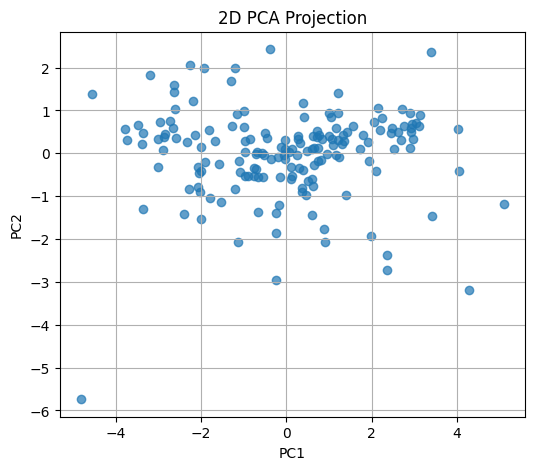

In [6]:

pca2 = PCA(n_components=2)
X2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('2D PCA Projection')
plt.grid(True)
plt.show()

# k-Means on 2D PCA

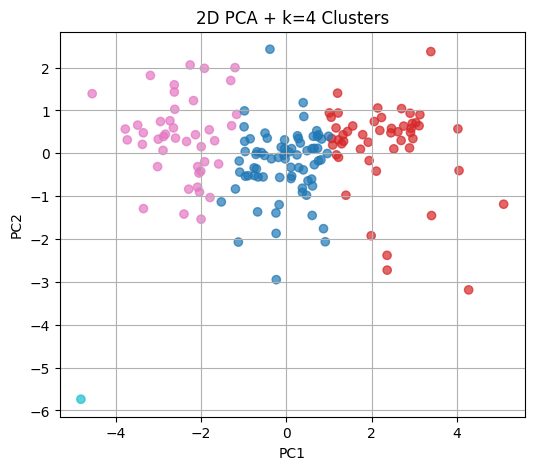

In [7]:
k2 = KMeans(n_clusters=4, random_state=42)
labels2 = k2.fit_predict(X2)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=labels2, cmap='tab10', alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('2D PCA + k=4 Clusters')
plt.grid(True)
plt.show()

# 3D PCA & Pairwise Plots

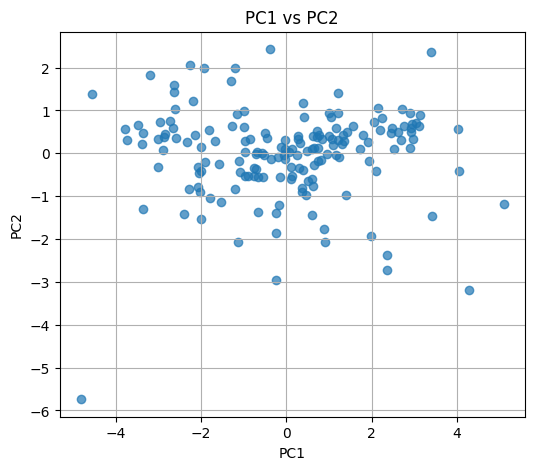

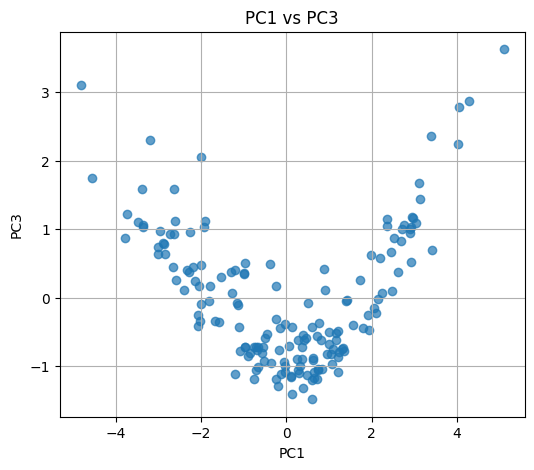

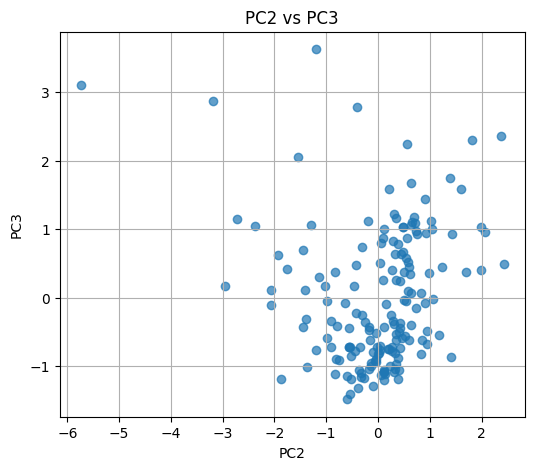

In [8]:
pca3 = PCA(n_components=3)
X3 = pca3.fit_transform(X_scaled)

pairs = [(0,1), (0,2), (1,2)]
for i,j in pairs:
    plt.figure(figsize=(6,5))
    plt.scatter(X3[:,i], X3[:,j], alpha=0.7)
    plt.xlabel(f'PC{i+1}'); plt.ylabel(f'PC{j+1}')
    plt.title(f'PC{i+1} vs PC{j+1}')
    plt.grid(True)
    plt.show()

# k-Means on 3D PCA

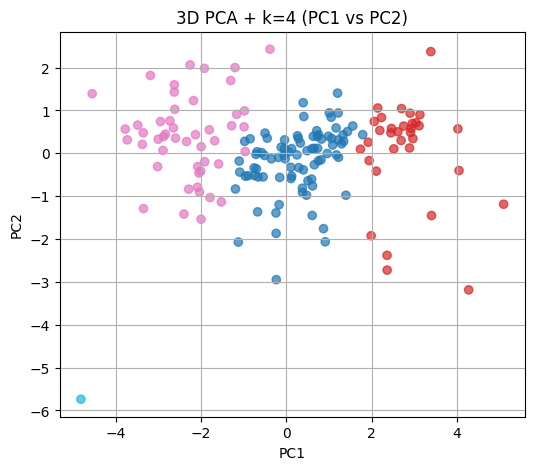

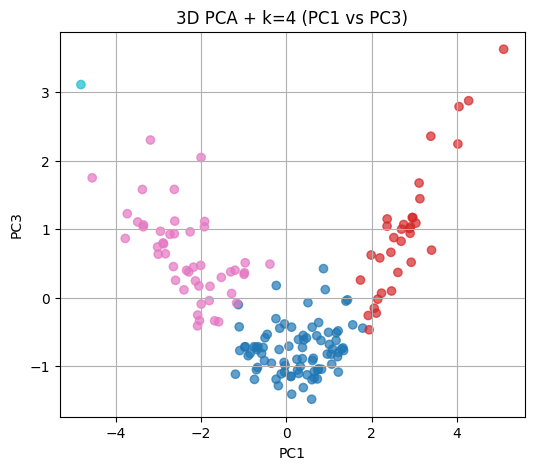

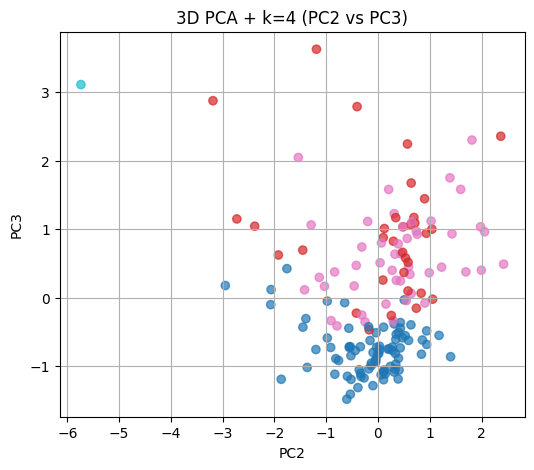

In [9]:
k3 = KMeans(n_clusters=4, random_state=42)
labels3 = k3.fit_predict(X3)

for i,j in pairs:
    plt.figure(figsize=(6,5))
    plt.scatter(X3[:,i], X3[:,j], c=labels3, cmap='tab10', alpha=0.7)
    plt.xlabel(f'PC{i+1}'); plt.ylabel(f'PC{j+1}')
    plt.title(f'3D PCA + k=4 (PC{i+1} vs PC{j+1})')
    plt.grid(True)
    plt.show()

In [10]:
k_orig = KMeans(n_clusters=4, random_state=42)
labels_orig = k_orig.fit_predict(X_scaled)

# Compare Clusterings (Adjusted Rand Index)

In [11]:
ari_o2 = adjusted_rand_score(labels_orig, labels2)
ari_o3 = adjusted_rand_score(labels_orig, labels3)
ari_23 = adjusted_rand_score(labels2, labels3)

print("Adjusted Rand Index:")
print(f"  Original vs 2D PCA : {ari_o2:.3f}")
print(f"  Original vs 3D PCA : {ari_o3:.3f}")
print(f"  2D PCA vs 3D PCA    : {ari_23:.3f}")

Adjusted Rand Index:
  Original vs 2D PCA : 0.647
  Original vs 3D PCA : 0.962
  2D PCA vs 3D PCA    : 0.645


## Practical Implications

- **Dimensionality reduction:** The first two PCs already capture most variance, enabling clear visualization.  
- **Cluster robustness:** High ARI scores indicate that clustering in reduced spaces closely matches the original high-dimensional segmentation.  
- **Aid allocation:**  
  - **Cluster 1** (e.g., high child_mort + low health spending) → prioritize health infrastructure.  
  - **Cluster 2** (low income + high fertility) → focus on income-generation and family planning.  
  - … and so on.  

Reducing to 2–3 dimensions simplifies stakeholder communication without losing actionable group structure.